In [9]:
import os
import re
import csv
import itertools

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [11]:
import pytorch_pretrained_bert
import wget

In [12]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

2022-10-04 22:10:11.185366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 22:10:11.247240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cudalib64:/usr/lib/cuda/lib64/:/usr/local/cuda/lib64/:
2022-10-04 22:10:11.247430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cudalib64:/usr/lib/cuda/lib64

SystemError: GPU device not found

In [13]:
# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-PCIE-32GB


In [14]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

Traceback (most recent call last):
  File "/home/server_admin/anaconda3/envs/Chandan/bin/transformers-cli", line 5, in <module>
    from transformers.commands.transformers_cli import main
  File "/home/server_admin/anaconda3/envs/Chandan/lib/python3.9/site-packages/transformers/commands/transformers_cli.py", line 24, in <module>
    from .pt_to_tf import PTtoTFCommand
  File "/home/server_admin/anaconda3/envs/Chandan/lib/python3.9/site-packages/transformers/commands/pt_to_tf.py", line 21, in <module>
    from datasets import load_dataset
ModuleNotFoundError: No module named 'datasets'


In [15]:
!dir biobert_v1.1_pubmed/
!move biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!dir biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
/bin/bash: move: command not found
bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [16]:
!dir

\ biobert_ner.ipynb  bionlp_tags.csv  medical_transcripts_kaggle
biobert_v1.1_pubmed  Data


In [17]:
MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = BertTokenizer(vocab_file='biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [18]:
data = pd.read_csv('./bionlp_tags.csv')
tag_values = data['tags'].values
vocab_len = len(tag_values)
print('Entity Types:',vocab_len)

Entity Types: 74


In [19]:
df_tags = pd.DataFrame({'tags':tag_values})
df_tags.to_csv('bionlp_tags.csv',index=False)
df = pd.read_csv('bionlp_tags.csv')
print('Tag Preview:\n', df)

Tag Preview:
                       tags
0     I-Cellular_component
1   E-Gene_or_gene_product
2   I-Organism_subdivision
3     I-Organism_substance
4   B-Gene_or_gene_product
..                     ...
69                 I-Organ
70                S-Cancer
71            B-Amino_acid
72     S-Anatomical_system
73                     PAD

[74 rows x 1 columns]


In [20]:
class SentenceFetch(object):
  
    def __init__(self, data):
        self.data = data
        self.sentences = []
        self.tags = []
        self.sent = []
        self.tag = []

        # make tsv file readable
        with open(self.data) as tsv_f:
            reader = csv.reader(tsv_f, delimiter='\t')
            for row in reader:
                if len(row) == 0:
                    if len(self.sent) != len(self.tag):
                        break
                    self.sentences.append(self.sent)
                    self.tags.append(self.tag)
                    self.sent = []
                    self.tag = []
                else:
                    self.sent.append(row[0])
                    self.tag.append(row[1])   

    def getSentences(self):
        return self.sentences

    def getTags(self):
        return self.tags

In [21]:
corpora = './Data/bionlp_corpora'
sentences = []
tags = []
for subdir, dirs, files in os.walk(corpora):
    for file in files:
        if file == 'train.tsv':
            path = os.path.join(subdir, file)
            sent = SentenceFetch(path).getSentences()
            tag = SentenceFetch(path).getTags()
            sentences.extend(sent)
            tags.extend(tag)
            
sentences = sentences[0:20000]
tags = tags[0:20000]

In [22]:
sentences

[['Novel',
  'Algorithms',
  'Reveal',
  'Streptococcal',
  'Transcriptomes',
  'and',
  'Clues',
  'about',
  'Undefined',
  'Genes'],
 ['Bacteria',
  '-',
  'host',
  'interactions',
  'are',
  'dynamic',
  'processes',
  ',',
  'and',
  'understanding',
  'transcriptional',
  'responses',
  'that',
  'directly',
  'or',
  'indirectly',
  'regulate',
  'the',
  'expression',
  'of',
  'genes',
  'involved',
  'in',
  'initial',
  'infection',
  'stages',
  'would',
  'illuminate',
  'the',
  'molecular',
  'events',
  'that',
  'result',
  'in',
  'host',
  'colonization',
  '.'],
 ['We',
  'used',
  'oligonucleotide',
  'microarrays',
  'to',
  'monitor',
  '(',
  'in',
  'vitro',
  ')',
  'differential',
  'gene',
  'expression',
  'in',
  'group',
  'A',
  'streptococci',
  'during',
  'pharyngeal',
  'cell',
  'adherence',
  ',',
  'the',
  'first',
  'overt',
  'infection',
  'stage',
  '.'],
 ['We',
  'present',
  'neighbor',
  'clustering',
  ',',
  'a',
  'new',
  'computatio

In [23]:
print('Sentence Preview:\n',sentences[0])

Sentence Preview:
 ['Novel', 'Algorithms', 'Reveal', 'Streptococcal', 'Transcriptomes', 'and', 'Clues', 'about', 'Undefined', 'Genes']


In [24]:
def tok_with_labels(sent, text_labels):
    '''tokenize and keep labels intact'''
    tok_sent = []
    labels = []
    for word, label in zip(sent, text_labels):
        tok_word = tokenizer.tokenize(word)
        n_subwords = len(tok_word)

        tok_sent.extend(tok_word)
        labels.extend([label] * n_subwords)
    return tok_sent, labels

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]

In [25]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

In [26]:
len(tok_texts)

20000

In [27]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [28]:
print('WordPiece Tokenizer Preview:\n', tok_texts[0])

WordPiece Tokenizer Preview:
 ['Novel', 'Al', '##gor', '##ith', '##ms', 'Rev', '##eal', 'St', '##re', '##pt', '##oc', '##oc', '##cal', 'Trans', '##cript', '##ome', '##s', 'and', 'C', '##lue', '##s', 'about', 'Un', '##de', '##fine', '##d', 'Gene', '##s']


In [29]:
tag_values = list(set(itertools.chain.from_iterable(tags)))
tag_values.append("PAD")

tag2idx = {t: i for i,t in enumerate(tag_values)}

In [30]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [31]:
# attention masks make explicit reference to which tokens are actual words vs padded words
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [32]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [33]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)


In [35]:
config = BertConfig.from_json_file('./biobert_v1.1_pubmed/bert_config.json')
tmp_d = torch.load('biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [36]:
class BioBertNER(nn.Module):

    def __init__(self, vocab_len, config, state_dict):
        super().__init__()
        self.bert = BertModel(config)
        self.bert.load_state_dict(state_dict, strict=False)
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encl = encoded_layer[-1]
        out = self.dropout(encl)
        out = self.output(out)
        return out, out.argmax(-1)

In [37]:
model = BioBertNER(vocab_len,config,state_dict)
model.to(device)

BioBertNER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

In [41]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)
epochs = 10
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [42]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    for step,batch in enumerate(data_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs,y_hat = model(b_input_ids,b_input_mask)
        
        _,preds = torch.max(outputs,dim=2)
        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)
        loss = loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [43]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)
            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
        
    
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [44]:
%%time
history = defaultdict(list)
best_accuracy = 0
normalizer = BATCH_SIZE*MAX_LEN
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    train_acc = train_acc/normalizer
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)  
    loss_values.append(avg_train_loss)
    
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    val_acc = val_acc/normalizer
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

======== Epoch 1/10 ========
Train Loss: 0.255314233009811 Train Accuracy: 0.935341918294849
Val Loss: 0.11792599498516038 Val Accuracy: 0.9508597883597885
======== Epoch 2/10 ========
Train Loss: 0.09571315327305248 Train Accuracy: 0.9641918294849023
Val Loss: 0.09132596365516148 Val Accuracy: 0.9551785714285713
======== Epoch 3/10 ========
Train Loss: 0.0682097120710101 Train Accuracy: 0.9716133806986382
Val Loss: 0.08768900276886092 Val Accuracy: 0.9579100529100529
======== Epoch 4/10 ========
Train Loss: 0.055806555846444665 Train Accuracy: 0.9747624333925401
Val Loss: 0.08171993322552197 Val Accuracy: 0.9616402116402117
======== Epoch 5/10 ========
Train Loss: 0.048347430343393956 Train Accuracy: 0.9766629662522203
Val Loss: 0.08198298602586701 Val Accuracy: 0.9619576719576719
======== Epoch 6/10 ========
Train Loss: 0.0441151427181163 Train Accuracy: 0.9780150976909414
Val Loss: 0.08232092804142407 Val Accuracy: 0.9612301587301587
======== Epoch 7/10 ========
Train Loss: 0.041238

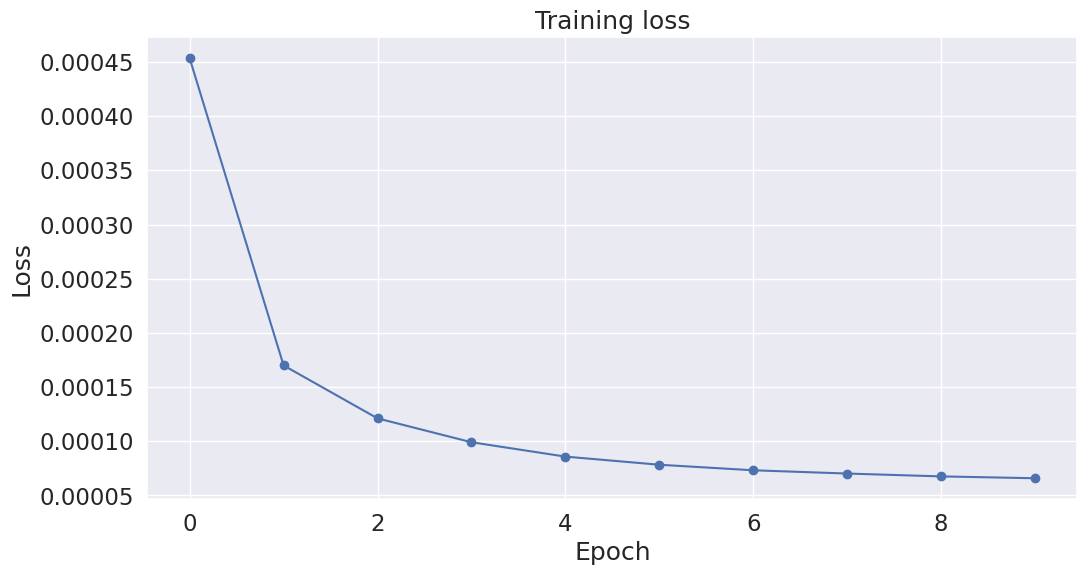

In [45]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Test

In [46]:
text = """In addition to their essential catalytic role in protein biosynthesis, aminoacyl-tRNA synthetases participate in numerous other functions, including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein, we describe a class of aminoacyl-tRNA synthetase-like (HisZ) proteins based on the catalytic core of the contemporary class II histidyl-tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase (HisG). Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics, a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy, and three other lines of evidence support the direct involvement of HisZ in the transferase function. (i) Genetic experiments demonstrate that complementation of an in-frame deletion of HisG from Escherichia coli (which does not possess HisZ) requires both HisG and HisZ from L. lactis. (ii) Coelution of HisG and HisZ during affinity chromatography provides evidence of direct physical interaction. (iii) Both HisG and HisZ are required for catalysis of the ATP phosphoribosyltransferase reaction. This observation of a common protein domain linking amino acid biosynthesis and protein synthesis implies an early connection between the biosynthesis of amino acids and proteins."""


In [48]:
text

'In addition to their essential catalytic role in protein biosynthesis, aminoacyl-tRNA synthetases participate in numerous other functions, including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein, we describe a class of aminoacyl-tRNA synthetase-like (HisZ) proteins based on the catalytic core of the contemporary class II histidyl-tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase (HisG). Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics, a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy, and three other lines of evidence support the direct involvement of HisZ in the transferase function. (i) Genetic experiments demonstrate that complementatio

In [49]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/server_admin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [50]:
sent_text = nltk.sent_tokenize(text)

In [52]:
tokenized_text = []
for sentence in sent_text:
    tokenized_text.append(nltk.word_tokenize(sentence))

In [53]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []
    
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word)   
        tokenized_sentence.extend(tokenized_word)

    return tokenized_sentence

In [54]:
tok_texts = [
    tokenize_and_preserve(sent) for sent in tokenized_text
]

In [55]:
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
input_attentions = [[1]*len(in_id) for in_id in input_ids]

In [56]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[1])
new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        
        new_tokens.append(token)

In [57]:
actual_sentences = []
pred_labels = []
for x,y in zip(input_ids,input_attentions):
    x = torch.tensor(x).cuda()
    y = torch.tensor(y).cuda()
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

In [58]:
for token, label in zip(actual_sentences, pred_labels):
    for t,l in zip(token,label):
        print("{}\t{}".format(t, l))

In	O
addition	O
to	O
their	O
essential	O
catalytic	O
role	O
in	O
protein	O
biosynthesis	O
,	O
aminoacyl	O
-	O
tRNA	O
synthetases	O
participate	O
in	O
numerous	O
other	O
functions	O
,	O
including	O
regulation	O
of	O
gene	O
expression	O
and	O
amino	O
acid	O
biosynthesis	O
via	O
transamidation	O
pathways	O
.	O
Herein	O
,	O
we	O
describe	O
a	O
class	O
of	O
aminoacyl	O
-	O
tRNA	O
synthetase	O
-	O
like	O
(	O
HisZ	O
)	O
proteins	O
based	O
on	O
the	O
catalytic	O
core	O
of	O
the	O
contemporary	O
class	O
II	O
histidyl	O
-	O
tRNA	O
synthetase	O
whose	O
members	O
lack	O
aminoacylation	O
activity	O
but	O
are	O
instead	O
essential	O
components	O
of	O
the	O
first	O
enzyme	O
in	O
histidine	O
biosynthesis	O
ATP	O
phosphoribosyltransferase	O
(	O
HisG	O
)	O
.	O
Prediction	O
of	O
the	O
function	O
of	O
HisZ	O
in	O
Lactococcus	B-Organism
lactis	I-Organism
was	O
assisted	O
by	O
comparative	O
genomics	O
,	O
a	O
technique	O
that	O
revealed	O
a	O
link	O
between	O
the	O
presence	O
or	O
the	O
absence	O
of	O
HisZ	

In [60]:
model_save = 'BIONER_classifier.pt'
path = F"models/{model_save}" 
torch.save(model.state_dict(), path)